# Ames House Price Data - Random Forest Model

> Juptyer notebook, running a Julia 0.5.2 kernel, with the help of Machine Learning modules written by the author

*In this section we build a random forest regression model using just the 11 most important features, and include Breiman's bagging of patterns. More detail is provided here than for the other models*, to familiarize the reader with our extension of the ScikitLearn API.

*One may regard bagging as form of regularization. An experimental option utilized here is to lower the regularization by using "partial bagging"*

Error for this model on the [Kaggle public test set](https://www.kaggle.com/c/house-prices-advanced-regression-techniques): 0.17121 

## Reading in a feature-reduced data set

In [1]:
addprocs(3) # to allow parallel processing
using ADBUtilities, Regressors, TreeCollections
import DataFrames: DataFrame, head, readtable, writetable

feature_names = readtable("3.important_features/important_features.csv")[1:11,:field]
features = map(feature_names) do x
    Symbol(x) 
end
features = convert(Vector{Symbol}, features)
df = readtable("2.cleaned/train_randomized.csv")
const X = DataTable(df[features]) 
const y = collect(df[:target]);

## Defining train and validation iterators
Rather than constructing separate train and validation data sets, we define iterables that "point" to the indices of the patterns in each of these sets (these are called *bags* in the docstrings):

In [18]:
using Validation

n_patterns = length(y)
train, valid = split_bag(1:n_patterns, 70) # 70% train, 30% validate

([1,2,3,4,5,6,7,8,9,10  …  1010,1011,1012,1013,1014,1015,1016,1017,1018,1019],[1020,1021,1022,1023,1024,1025,1026,1027,1028,1029  …  1447,1448,1449,1450,1451,1452,1453,1454,1455,1456])

## Single decision trees
A single decision tree can be instantiated with default parameters as follows:

In [19]:
tree=TreeRegressor()

unfitted TreeRegressor@...5592

In [20]:
@more # shorthand for showall(ans)

Dict{Symbol,Any} with 6 entries:
  :max_features       => 0
  :extreme            => false
  :regularization     => 0.0
  :min_patterns_split => 2
  :cutoff             => 0
  :penalty            => 0.0

unfitted TreeRegressor@...5592
  Hyperparameters:


The default setting `min_patterns_split` is the minimum number of training patterns reaching a node for us to consider a new split there. We'll change this parameter, fit to the training set, and computer the RMS error on the validation set:

In [21]:
tree.min_patterns_split=5
fit!(tree, X, y, train)

TreeRegressor@...5592

In [22]:
@more

Dict{Symbol,Any} with 6 entries:
  :max_features       => 0
  :extreme            => false
  :regularization     => 0.0
  :min_patterns_split => 5
  :cutoff             => 0
  :penalty            => 0.0

TreeRegressor@...5592
  Hyperparameters:
                           Feature importance
                ┌────────────────────────────────────────┐ 
    OverallQual │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 1.0 │ 
     GarageCars │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.8        │ 
      GrLivArea │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.6               │ 
      LandSlope │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.5                  │ 
     BsmtFinSF1 │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.5                  │ 
       SaleType │▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.4                      │ 
     Fireplaces │▪▪▪▪▪▪▪ 0.2                             │ 
   TotRmsAbvGrd │▪▪▪▪▪▪▪ 0.2                             │ 
       MSZoning │▪▪▪▪ 0.1                                │ 
         MoSold │ 0.0                                    │ 
     MSSubClass │ 0.0                                    │ 
                └────────────────────────────────────────┘ 


In [23]:
rms_error(tree, X, y, valid)

0.21894639812005134

Or, in one line:

In [24]:
rms_error(TreeRegressor(X, y, train, min_patterns_split=3), X, y, valid)

0.22069373534970432

Cross-validation errors are obtained as follows:

In [25]:
full = vcat(train, valid)
errors = cv_errors(tree, X, y, full, n_folds = 12)
mean(errors)

fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,fold 11,fold 12,


0.20432495435370157


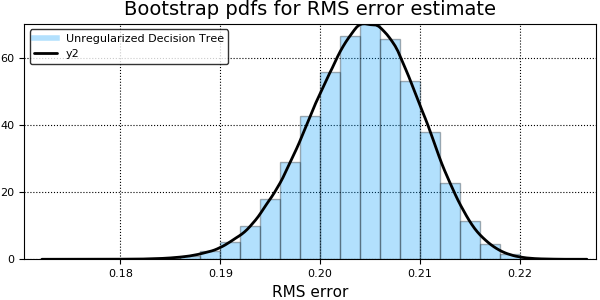

In [26]:
using Plots, ADBPlots
pyplot(size=(600,300))
bootstrap_histogram(errors, label="Unregularized Decision Tree")
plot!(xlab="RMS error", title="Bootstrap pdfs for RMS error estimate")


## Tuning a single parameter
Our decision trees have a regularization parameter `regularization` which, when non-zero, will arrange predictions at a leaf see values of the target for training patterns reaching nearby leaves. The larger the value of `regularization`, the more the prediction is affected by nearby leaves; when `regularization=0` the prediction is, as usual, the average of all target values of training patterns that reach the same leaf as the input pattern. 

To optimize `regularization` we shall make use of a convenient macro, @getfor from the ADBUtilities module. (An alternative to the ScikitLearn gridsearch function, which can also be imported.) The code,

    @getfor var range code 

evaluates `code`, replacing appearances of `var` therein with each value in `range`. The `range` and corresponding evaluations are returned as a tuple of arrays, which is convenient for plotting. For example,

    @getfor  x 1:3 (x^2 + 1)

evaluates to 

    ([1,2,3], [2, 5, 10])

In [27]:
u, v = @getfor ρ linspace(0.75,0.99,20) cv_error(TreeRegressor(regularization=ρ),
X, y, full, verbose=false)

([0.75,0.762632,0.775263,0.787895,0.800526,0.813158,0.825789,0.838421,0.851053,0.863684,0.876316,0.888947,0.901579,0.914211,0.926842,0.939474,0.952105,0.964737,0.977368,0.99],[0.176501,0.175908,0.175346,0.174819,0.17433,0.173884,0.173487,0.173141,0.172852,0.172624,0.17246,0.172364,0.172338,0.172384,0.172505,0.172701,0.17297,0.173313,0.173728,0.174211])


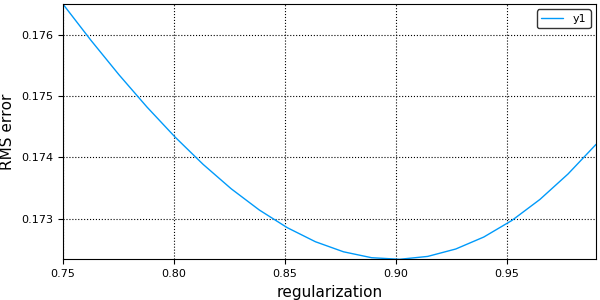

In [28]:
plot(u,v; xlab="regularization", ylab="RMS error")

fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,fold 11,fold 12,



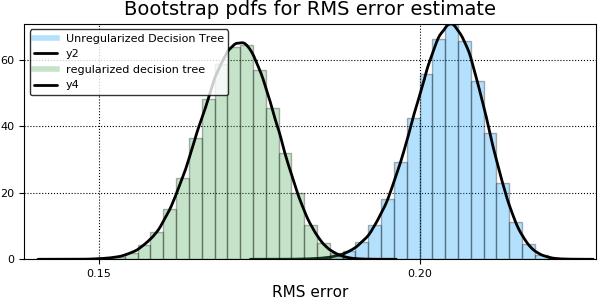

In [30]:
tree.regularization=0.9
errors_reg=cv_errors(tree, X, y, full, n_folds=12)
bootstrap_histogram(errors, label="Unregularized Decision Tree")
bootstrap_histogram!(errors_reg, label="regularized decision tree")
plot!(xlab="RMS error", title="Bootstrap pdfs for RMS error estimate")

Evidentally, a statistically signicant improvement.
## Bagged Regressors
A regressor type called `BaggedRegressor`, allows one to apply Breiman's bagging technique to obtain an ensemble of regressors of any fixed type; each member of the ensemble is a clone of some instance `atom`. A random forest (with standard bagging) is obtained as a special case:"

In [31]:
tree = TreeRegressor(max_features=3)
forest = BaggedRegressor(X,y,train; atom=tree, n=20)


Now cloning and fitting regressor number: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,


BaggedRegressor{Regressors.TreeRegressor}@...3270

Training can be parallelized:

In [32]:
forest = BaggedRegressor(X,y,train; atom=TreeRegressor(), n=20, parallel=true)

Ensemble-building in parallel on 3 processors.
	From worker 2:	
	From worker 3:	
	From worker 4:	
	From worker 2:	Now cloning and fitting regressor number: 1,2,3,4,5,6,
	From worker 3:	Now cloning and fitting regressor number: 1,2,3,4,5,6,
	From worker 4:	Now cloning and fitting regressor number: 1,2,3,4,5,6,7,8,


BaggedRegressor{Regressors.TreeRegressor}@...0426

In [33]:
forest.n_iter

20

We can add more trees to the ensemble:

In [34]:
add!(forest, X, y, train; n=10, parallel=true)

Ensemble-building in parallel on 3 processors.
	From worker 2:	
	From worker 3:	
	From worker 4:	
	From worker 2:	Now cloning and fitting regressor number: 1,2,3,
	From worker 3:	Now cloning and fitting regressor number: 1,2,3,
	From worker 4:	Now cloning and fitting regressor number: 1,2,3,4,


BaggedRegressor{Regressors.TreeRegressor}@...0426

In [35]:
forest.n_iter

30

And compute a learning curve to the determine number of iterations required for convergence (by default the RMS error is used):

In [36]:
iters_to_plot = 1:5:100
curve = learning_curve(forest, X, y, train, valid, iters_to_plot; 
    parallel=true, verbose=false, )

([1.0,6.0,11.0,16.0,21.0,26.0,31.0,36.0,41.0,46.0,51.0,56.0,61.0,66.0,71.0,76.0,81.0,86.0,91.0,96.0],[0.218115,0.164188,0.160418,0.159768,0.160435,0.160195,0.159593,0.158633,0.158685,0.157678,0.157183,0.157043,0.156622,0.157521,0.157743,0.157324,0.157224,0.157209,0.15715,0.156829])


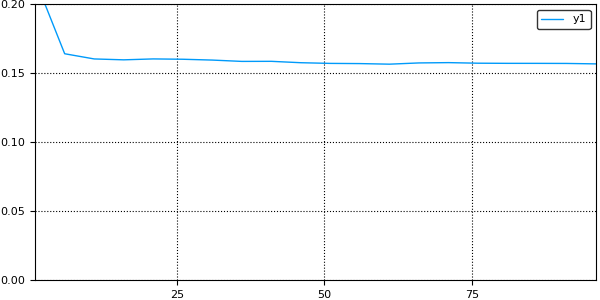

In [37]:
plot(curve, ylim=(0,0.2))

Or plot several such curves:


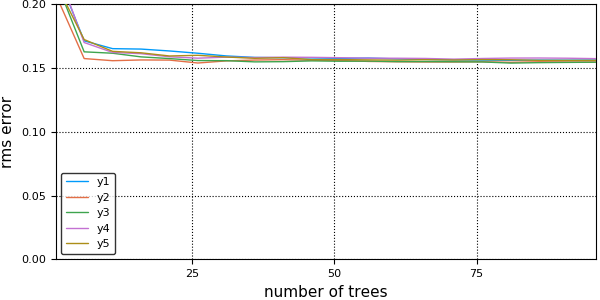

In [18]:
plt=plot(;xlab="number of trees", ylab="rms error", ylim=(0,0.2));
for _ in 1:5
    plot!(learning_curve(forest, X, y, train, valid, iters_to_plot, verbose=false))
end
plt

## Partial bagging
In standard bagging one creates a so-called bootstrap sample on which to train each member of the ensemble. Each such sample is constructed by sampling the original patterns *with replacement* until one has a set of patterns of the same size as the original training set. In partial bagging, a given sample is instead replaced with probability `bagging`, where `bagging` is now a tunable parameter between 0 and 1; when `bagging=1` we have standard bagging.

In [41]:
tree = TreeRegressor(max_features=3)
u, v = @getfor β linspace(0.5,1.0,15) rms_error(
    BaggedRegressor(X, y, train; atom=tree, n=500, bagging=β, parallel=true), 
    X, y, valid)

Ensemble-building in parallel on 3 processors.
	From worker 3:	
	From worker 4:	
	From worker 2:	
	From worker 4:	Now cloning and fitting regressor number: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,
	From worker 3:	Now cloning and fitting regressor number: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77

([0.5,0.535714,0.571429,0.607143,0.642857,0.678571,0.714286,0.75,0.785714,0.821429,0.857143,0.892857,0.928571,0.964286,1.0],[0.151209,0.150079,0.15067,0.150267,0.149803,0.150819,0.150229,0.150315,0.150414,0.150169,0.150598,0.150218,0.150315,0.149078,0.151247])


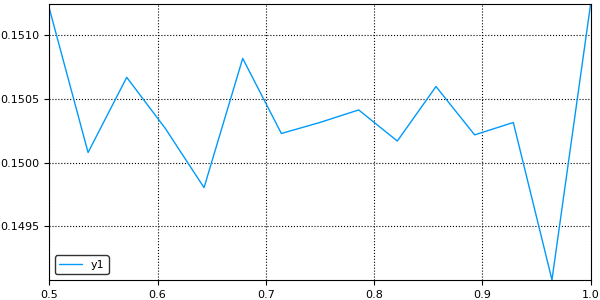

In [43]:
plot(u,v)

In [ ]:
u,v = @getfor b logspace(-2,0,20) rms_error(BaggedRegressor(X,y,train;atom=tree,n=1000,bagging=b, verbose=false, parallel=true), X, y, valid)

b=0.01 
b=0.012742749857031341 


In [ ]:
plot(u,v)

This plot suggests we perform no bagging at all. 
## Tuning `max_features` and `min_patterns_split`
With bagging turned off, we will train these other parameters with a two-variable version of the `@getfor` macro. For fine tuning we will use cross-validation.


In [ ]:
fit!(TreeRegressor(max_features=1,min_patterns_split=2), X,y, train)

In [ ]:
u,v,w = @getfor maxf 1:11 minp 2:5 rms_error(
    BaggedRegressor(X, y, train, 
        atom = TreeRegressor(max_features=maxf, min_patterns_split=minp),
        n=200, parallel=true, verbose=false), 
    X, y, valid);

In [ ]:
labels=map(v) do x
    string("min_patterns_split=",x)
end

In [ ]:
plot(u,w,label=labels,xlab="max_features",ylab="RMS error")

And now for the fine tuning:

In [ ]:
u,v,w = @getfor maxf 2:5 minp 2:5 cv_error(
    BaggedRegressor(atom=TreeRegressor(max_features=maxf, min_patterns_split=minp), n=200), 
    X, y, full, verbose=false, parallel=true, n_folds=9);

In [ ]:
labels=map(v) do x
    string("min_patterns_split=",x)
end
plot(u,w,label=labels,xlab="max_features",ylab="RMS error")